# Home Work 1


## Description.

Apply your knowledge about Fully-Connected NNs so far to solve several classification tasks


## Evaluation.

Along with every graded task you will see the maximum grading possible for it placed in (parenthesis). Grade might be lowered. The clear indicator that you won't get a maximum amount of points for a task is that your code does not work and/or your NN is not training. In order to obtain the maximum points you have to have sufficient accuracy >90%


### Good luck!

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import tqdm
import seaborn as sns
sns.set_style("darkgrid")
import copy

## Data

This is a toy dataset. <br>
$x \in \mathbb{R}^2, y \in \{0, 1\}$

In [ ]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [ ]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


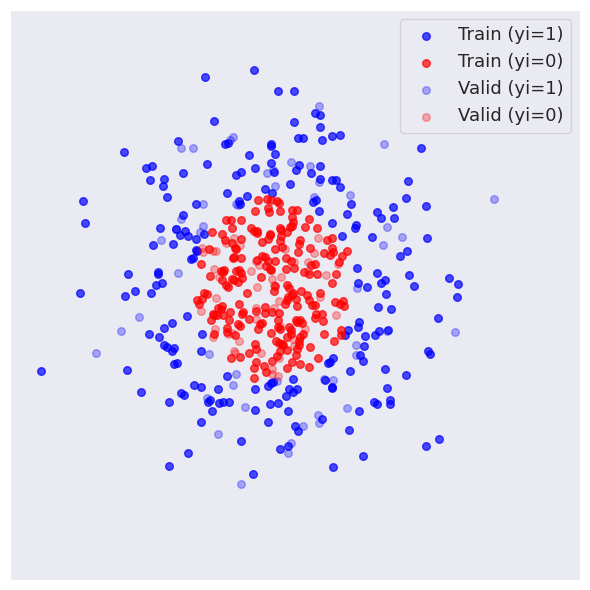

In [ ]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()
plt.grid()

## NN declaration (1 points)

You need to implement a class for a simple FC NN. Add as many layers and as many neurons as you'd like.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_classes = 2

        self.model = nn.Sequential(
            nn.Linear(self.n_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        outp = self.model(x)
        return outp.reshape(-1)

##  Train function. (1.5 points)
Add missing parts

In [ ]:
def train(model, loss_fn, opt, n_epochs, batch_size, lr, X_train, y_train, X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    # Why? Just why?
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None

    optimizer = optims[opt](model.parameters(), lr=lr)

    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None
    loss_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y in zip(x_train_loader, y_train_loader): # Zip was forgotten here
                #forward
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = (y_pred.round() == y).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
                bar.update(1) # Update bar in tqdm
        # evaluate accuracy at end of each epoch
        loss_history.append(loss.item())
        if X_val is not None and y_val is not None: # It is written simply logically. It doesn't make sense
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
            if acc > 0.98:
                break
    # restore model and return best accuracy


    model.load_state_dict(best_weights)

    return model, loss_history

### Train the network. (1 point)

Train NN three times: with three different optimization algorithms. Don't forget to reinitialize model before each train. Make sure you pass the correct arguments to opt.

**Hint** It is better to have three different objects - model1, model2, and model3

In [ ]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

# Why would I ever use a dictionary?
optims = {'optim1': torch.optim.SGD, # Use SGD
          'optim2' : torch.optim.Adam, # Use Adam
          'optim3' : torch.optim.RMSprop # Use RMSProp
}

model = NeuralNetwork()
model1, loss_SGD = train(model, loss_fn=nn.BCELoss(), opt='optim1', n_epochs=25, batch_size=32,
               lr=4e-2, X_train=X_train_torch, y_train=y_train_torch, X_val=X_valid_torch, y_val=y_valid_torch)

Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 44.86batch/s, acc=0.688, loss=0.589]


In [ ]:
model = NeuralNetwork()
model2, loss_Adam = train(model, loss_fn=nn.BCELoss(), opt='optim2', n_epochs=25, batch_size=32,
               lr=3e-3, X_train=X_train_torch, y_train=y_train_torch, X_val=X_valid_torch, y_val=y_valid_torch)

Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 50.09batch/s, acc=1, loss=0.0397]


In [ ]:
model = NeuralNetwork()
model3, loss_rmsprop = train(model, loss_fn=nn.BCELoss(), opt='optim3', n_epochs=25, batch_size=32,
               lr=3e-2, X_train=X_train_torch, y_train=y_train_torch, X_val=X_valid_torch, y_val=y_valid_torch)

Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 86.80batch/s, acc=1, loss=0.0553]


### А теперь посмотрим на графики лоссов

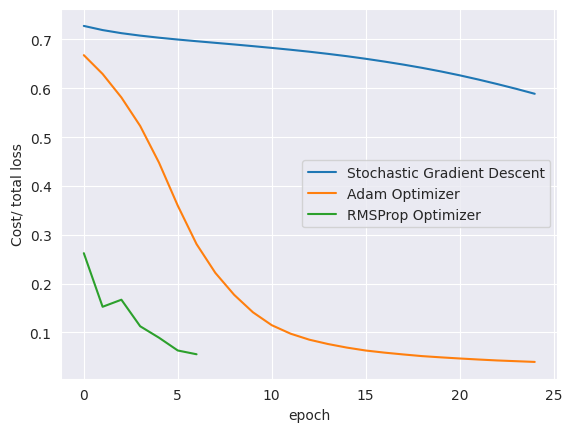

In [ ]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

## Now solve multi-class task (2.5 points)

You are welcome to use anything you know.


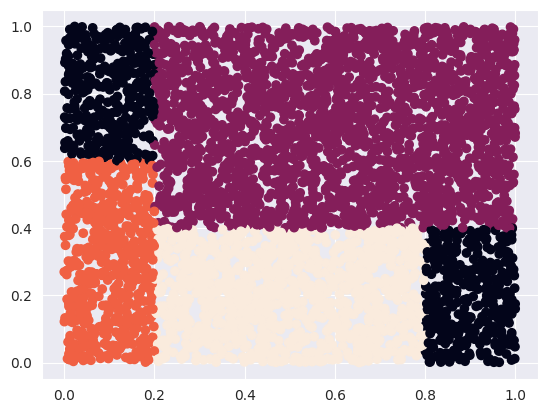

In [ ]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train_data = data[:800]
validation_data = data[800:900]
test_data = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [ ]:
class AdvancedModel(nn.Module):
    def __init__(self,):
        super(AdvancedModel, self).__init__()
        self.n_classes = 4
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),

            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, self.n_classes),
            nn.BatchNorm1d(self.n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        primary_output = self.model(x)
        return primary_output

In [ ]:
def train_model(model, optimizer, loss_fn, n_epochs, batch_size, X_train, y_train, X_val=None, y_val=None, shuffle=False):
    x_train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle, generator=torch.Generator().manual_seed(42))
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = DataLoader(X_val, batch_size=1) if X_val is not None else None
    y_val_ld = DataLoader(y_val, batch_size=1) if y_val is not None else None


    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None
    loss_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for x, y, start in zip(x_train_loader, y_train_loader, bar): # Another way to update bar in tqdm
                y_pred = model(x)
                loss = loss_fn(y_pred, y.float())
                loss_history.append(loss.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = (y_pred.round() == y).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        if x_val_ld is not None and y_val_ld is not None:
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy

    model.load_state_dict(best_weights)

    return model, loss_history

In [ ]:
advanced_model = AdvancedModel()
advanced_model, advanced_loss = train_model(advanced_model, loss_fn=nn.BCEWithLogitsLoss(), optimizer=torch.optim.RMSprop(advanced_model.parameters(), lr=5e-3, eps=1e-7, momentum=.77),
                                            n_epochs=50, batch_size=64,
                                            X_train=train_data[:, :-1], y_train=F.one_hot(train_data[:, -1].to(torch.int64)),
                                            X_val=validation_data[:, :-1], y_val=F.one_hot(validation_data[:, -1].to(torch.int64)))

Epoch 49:  92%|█████████▏| 12/13 [00:00<00:00, 75.98batch/s, acc=0.953, loss=0.618]


In [ ]:
# Test

advanced_model.eval()
out = advanced_model(test_data[:, :-1])
acc = (out.round() == F.one_hot(test_data[:, -1].to(torch.int64))).float().mean()
loss = nn.BCEWithLogitsLoss()(out, F.one_hot(test_data[:, -1].to(torch.int64)).float())
print("Final test loss: {:.6f}".format(loss))
print("Final test accuracy: {:.4f}".format(acc))

Final test loss: 0.619681
Final test accuracy: 0.9689


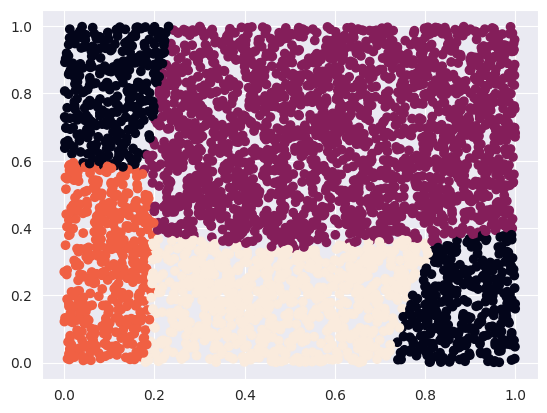

In [ ]:
plt.scatter(test_data[:,0],test_data[:,1],c = torch.argmax(out, dim=-1).detach().numpy())
None

## Stupdily Advanced Model

Здесь я уже развлекаюсь, собственно говоря.

In [ ]:
class StupidlyAdvancedModel(nn.Module):
    def __init__(self, n_classes, n_input):
        super(StupidlyAdvancedModel, self).__init__()
        self.n_classes = n_classes
        self.n_input = n_input

        self.model = nn.Sequential(
            nn.Linear(n_input, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        self.heads = nn.ModuleList([nn.Sequential(
            nn.Linear(16, 1),
            nn.Sigmoid()
        ) for _ in range(self.n_classes)])

        self._init_weights()

    def _init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        for head in self.heads:
            for m in head:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

    def forward(self, x):
        primary_output = self.model(x)
        outputs = [head(primary_output) for head in self.heads]
        return torch.cat(outputs, dim=1)

In [ ]:
stupidly_advanced_model = StupidlyAdvancedModel(n_classes=len(np.unique(data[:, -1])), n_input=data[:, :-1].shape[1])
stupidly_advanced_model, _ = train_model(stupidly_advanced_model, loss_fn=nn.BCELoss(),
                                            optimizer=torch.optim.RMSprop(stupidly_advanced_model.parameters(), lr=4.9e-3, momentum=.4), #3e-5
                                            n_epochs=50, batch_size=64,
                                            X_train=train_data[:, :-1], y_train=F.one_hot(train_data[:, -1].to(torch.int64)),
                                            X_val=validation_data[:, :-1], y_val=F.one_hot(validation_data[:, -1].to(torch.int64)))

Epoch 49:  92%|█████████▏| 12/13 [00:00<00:00, 66.10batch/s, acc=0.977, loss=0.117]


In [ ]:
# Test

stupidly_advanced_model.eval()
out = stupidly_advanced_model(test_data[:, :-1])
acc = (out.round() == F.one_hot(test_data[:, -1].to(torch.int64))).float().mean()
loss = nn.BCEWithLogitsLoss()(out, F.one_hot(test_data[:, -1].to(torch.int64)).float())
print("Final test loss: {:.6f}".format(loss))
print("Final test accuracy: {:.4f}".format(acc))

Final test loss: 0.617914
Final test accuracy: 0.9849


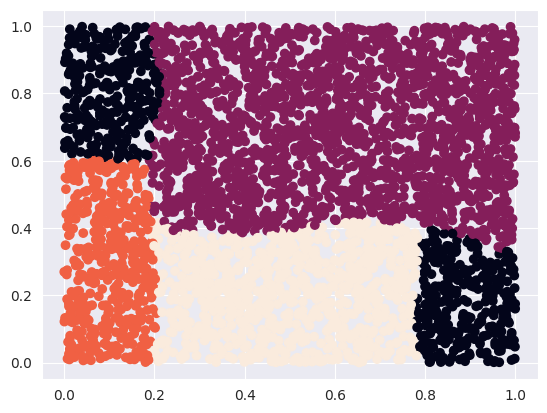

In [ ]:
plt.scatter(test_data[:,0],test_data[:,1],c = torch.argmax(out, dim=-1).detach().numpy())
None

## (Almost) Real task. (4 points)

This is alcohol classification task. You need to predict the target value.
Feel free to visualize and do whatever feels right to EDA and training model.
You can reuse previous models with slight changes or make a new one

In [ ]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
print(df.shape)
df.head()

(178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
X = df.loc[:, df.columns != 'target']
y = df.target

In [ ]:
X.shape, y.shape

((178, 13), (178,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long) # Issue with Series

In [ ]:
class WineModel(nn.Module):
    def __init__(self, n_classes, n_input):
        super(WineModel, self).__init__()
        self.n_classes = n_classes
        self.n_input = n_input
        self.model = nn.Sequential(
            nn.Linear(n_input, 16),
            nn.BatchNorm1d(16),
            nn.ELU(),

            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ELU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ELU(),

            nn.Linear(16, self.n_classes),
            nn.ELU()
        )

    def forward(self, x):
        primary_output = self.model(x)
        return primary_output

In [ ]:
real_task_model = WineModel(n_classes=len(df.target.unique()), n_input=X.shape[1])
real_task_model, _ = train_model(real_task_model, loss_fn=nn.MSELoss(), optimizer=torch.optim.AdamW(real_task_model.parameters(), lr=2e-3, weight_decay=.07),
                                            n_epochs=50, batch_size=32, shuffle=False,
                                            X_train=X_train_tensor, y_train=F.one_hot(y_train_tensor),
                                            X_val=torch.Tensor(X_val_tensor), y_val=F.one_hot(y_val_tensor))

Epoch 49:  80%|████████  | 4/5 [00:00<00:00, 80.80batch/s, acc=1, loss=0.0304] 


In [ ]:
# There is nothing left to test properly on